In [1]:
using MLDatasets
using ImageCore
using LinearAlgebra
using PyPlot
using Random
using Statistics
using Printf
using Quaternions
using JLD2, FileIO
using ProgressMeter
include("HyperRPNNs.jl")
rng = MersenneTwister(1234);

In [2]:
function cifar2gray(x)
    return round.(Int,255*(0.2989*x[:,:,1,1] + 0.5870*x[:,:,2,1]+ 0.1140*x[:,:,3,1]))
end

function gray2multistate(x,K)
    return exp.(2.0*pi*x*im/K)
end

function multistate2gray(y,K)
    return Array{Int64}((round.(K*(2*pi.+angle.(y))./(2*pi))).%K)
end

function imnoise(img,noise_std = 0.1)
    return clamp.(img + noise_std*randn(rng, Float64, size(img)),0,1)
end

function gray2bin(x,Nbits=8)
    y = Array{Int64}(undef,length(x),Nbits)
    for i=1:length(x)
        y[i,:] = 2*digits(x[i], base=2, pad = Nbits).-1
    end
    return y, size(x)
end

function bin2gray(y, xsize)
    return reshape([Int(sum(((y[i,:].+1)/2).*2 .^(0:size(y,2)-1))) for i=1:size(y,1)],xsize)
end

function gray2TwinMultistate(x,K)
    zbin,zsize = gray2bin(x,8)
    c1 = gray2multistate(bin2gray(zbin[:,1:4],zsize),K)
    c2 = gray2multistate(bin2gray(zbin[:,5:8],zsize),K)
    return hcat(real.(c1)[:],imag.(c1)[:],real.(c2)[:],imag.(c2)[:]), zsize
end

function TwinMultistate2gray(xc,K,xsize)
    c1, csize = gray2bin(multistate2gray(xc[:,1]+xc[:,2]*im,K),4)
    c2, csize = gray2bin(multistate2gray(xc[:,3]+xc[:,4]*im,K),4)
    return bin2gray(hcat(c1,c2),xsize)
end

TwinMultistate2gray (generic function with 1 method)

In [3]:
# load full training set
train_x, train_y = CIFAR10.traindata();

In [4]:
P = 200
# Indexes of the fundamental memories
indFM = randperm(rng, size(train_x)[4])[1:P];

In [5]:
N = 32*32;

alpha = 20/(2*N);
beta = -20;

P = 200;
K = 16;

Nsim = 100;
NoiseValues = range(0,stop=150,step=5)/255;
Nnoise = length(NoiseValues);

SuccessQuaternion_Sync = zeros(Int64,(Nnoise,));
SuccessQuaternion_Seq = zeros(Int64,(Nnoise,));

@showprogress for s = 1:Nsim
    # Generate the fundamental memory set!
    indFM = randperm(rng, size(train_x)[4])[1:P]
    U = Array{Real}(undef,N,4,P)
    for i=1:P
        uc, usize = gray2TwinMultistate(cifar2gray(train_x[:,:,:,indFM[i]]),K)
        U[:,:,i] = uc
    end

    
    for i = 1:Nnoise
        # Generate a corrupted pattern
        imgx = cifar2gray(train_x[:,:,:,indFM[1]])
        imgxr = cifar2gray(imnoise(train_x[:,:,:,indFM[1]],NoiseValues[i]))
        x, xsize = gray2TwinMultistate(imgxr,K)
        
                # Recall using synchronous update
        y, Energy = HyperRPNNs.Sync(HyperRPNNs.LambdaInner,[1,1,1,1],HyperRPNNs.twincsign,K,U,x,alpha,beta)
        imgy = TwinMultistate2gray(y,K,xsize)
        Error = norm(imgx-imgy)
        if Error<1.e-4
            SuccessQuaternion_Sync[i] = SuccessQuaternion_Sync[i] + 1
        end
        
    end
    @save "JLDs/CIFARQuaternion.jld2" SuccessQuaternion_Sync  NoiseValues Nsim
end

Progress: 100%|█████████████████████████████████████████| Time: 11:21:34


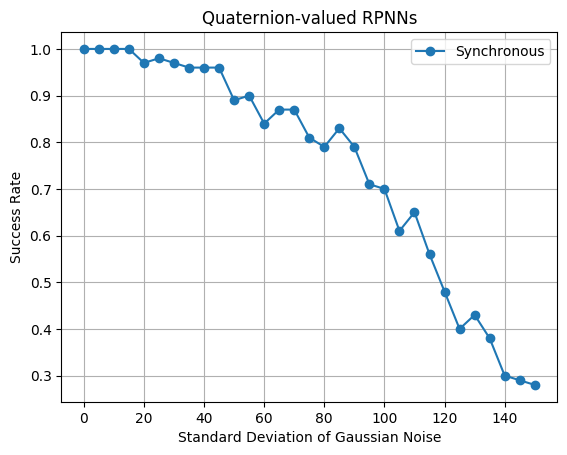

In [6]:
@load "JLDs/CIFARQuaternion.jld2"
plot(255*NoiseValues,SuccessQuaternion_Sync/Nsim, marker="o",label = "Synchronous")
title("Quaternion-valued RPNNs")
xlabel("Standard Deviation of Gaussian Noise")
ylabel("Success Rate")
legend()
grid()